Sealevel monitor
========

This document is used to monitor the current sea level along the Dutch coast. The sea level is measured using a number of tide gauges. Six long running tide gauges are considered "main stations". The mean of these stations is used to estimate the "current sea-level rise". The measurements since 1890 are taken into account. Measurements before that are considered less valid because the Amsterdam Ordnance Datum was not yet normalized. 

In [1]:
# this is a list of packages that are used in this notebook
# these come with python
import io
import zipfile
import functools
import bisect
import datetime
import pathlib

import sys
before = {str(m) for m in sys.modules}
# you can install these packages using pip or anaconda
# (requests numpy pandas bokeh pyproj statsmodels)

# for downloading
import requests
import netCDF4

# computation libraries
import numpy as np
import pandas as pd


# coordinate systems
import pyproj 

# statistics
import statsmodels.api as sm
import statsmodels.multivariate.pca
import statsmodels.tsa.seasonal


# plotting
import bokeh.io
import bokeh.plotting
import bokeh.tile_providers
import bokeh.palettes

# this package gives a lot of warnings about incompatibility with 3.1 
# replace 
import windrose
import matplotlib.colors
import matplotlib.cm
import matplotlib.pyplot as plt
matplotlib.projections.register_projection(windrose.WindroseAxes)
import cmocean.cm

# displaying things
from ipywidgets import Image
import IPython.display

# add the top level package
import slr.models
import slr.psmsl
import slr.wind
import slr.plots
import slr.tables


import slr

/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# Some settings for interactive plots
# If this notebook is not showing up with figures, you can use the following url:
# https://nbviewer.ipython.org/github/openearth/notebooks/blob/master/sealevelmonitor.ipynb
bokeh.io.output_notebook()
# we're using matplotlib for polar plots (non-interactive)
%matplotlib inline

src_dir = slr.get_src_dir()


Loading BokehJS ...

In [3]:
# use local data, make sure you updated the datasets with the makefiles
local = True

# Drop Delfzijl, because it contains uncorrected subsidence
drop_delfzijl = True

# Wind product should always be selected, because it is also used for plots and comparison to surge
wind_product = 'NCEP1'

# If you subtract surge, you should set with_wind to False
# When you set subtract surge to True 
subtract_surge = True
# Explicitly do not select wind, as we already correct for surge
# You can also set this to None to have it autopicked based on AIC
with_wind = False

# Define a reference point for the wind correction. This should be somewhere offshore, away for the coast. 
# This is needed because wind needs some length to generate the wind setup
reference_point_wind = {"lat": 53, "lon": 3}

# By default we analyse the annual data. If you switch to monthly you also should include some seasonal model. 
default_dataset_name = 'rlr_annual'




Sea-level measurements
=============
In this section we download sea-level measurements. The global collection of tide gauge records at the PSMSL is used to access the data. The other way to access the data is to ask the service desk data at Rijkswaterstaat. There are two types of datasets the "Revised Local Reference" and "Metric". For the Netherlands the difference is that the "Revised Local Reference" undoes the corrections from the  NAP correction in 2014, to get a consistent dataset. Here we transform the RLR back to NAP (without undoing the correction).

**Check:** Make sure that you verify the rlr2nap parameters.

The rlrnap computes the rlr back to  latest NAP (ignoring the undoing of the NAP correction) the alpha paramater is the dominant wind direction for the stations, based on de Ronde 2013. Id's are the station ids in the PSMSL dataset. They may change from year to year as the PSMSL 0 point is arbitary. You can lookup the relevant parameters in the schematic diagram like this: https://www.psmsl.org/data/obtaining/rlr.diagrams/20.php

In [4]:
zipfiles = slr.psmsl.get_zipfiles()
main_stations = slr.psmsl.get_main_stations()



In [5]:
# Check these numbers with the table
main_stations[['name', 'psmsl_id', 'msl-rlr', 'msl-nap', 'nap-rlr']]

,name,psmsl_id,msl-rlr,msl-nap,nap-rlr
id,,,,,
20,Vlissingen,20,6976,46,6930
22,Hoek van Holland,22,6987,114,6873
23,Den Helder,23,6962,16,6946
24,Delfzijl,24,6953,130,6823
25,Harlingen,25,7024,110,6914
32,IJmuiden,32,7014,64,6950


In [6]:
# the main stations are defined by their ids
main_stations_idx = list(main_stations.index)
main_stations_idx

[20, 22, 23, 24, 25, 32]

In [7]:
# download the zipfile

zipfile = zipfiles[default_dataset_name]
stations = slr.psmsl.get_station_list(zipfiles[default_dataset_name], dataset_name=default_dataset_name)
# the dutch stations in the PSMSL database, make a copy
# or use stations.coastline_code == 150 for all dutch stations
selected_stations = pd.merge(main_stations, stations, left_index=True, right_index=True, suffixes=['_rws', '_psmsl'])
# set the main stations, this should be a list of 6 stations
selected_stations['name'] = selected_stations['name_rws']
selected_stations

,name_rws,msl-rlr,msl-nap,nap-rlr,alpha,ddl_id,location,psmsl_id,foundation_low,station_low,...,lat,lon,name_psmsl,coastline_code,station_code,quality,met_monthly_url,rlr_monthly_url,rlr_annual_url,name
id,,,,,,,,,,,,,,,,,,,,,
20,Vlissingen,6976,46,6930,118,VLISSGN,Vlissingen,20,-17.6,2.50,...,51.442222,3.596111,VLISSINGEN,150,101,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,Vlissingen
22,Hoek van Holland,6987,114,6873,117,HOEKVHLD,Hoek van Holland,22,-3.3,5.27,...,51.977500,4.120000,HOEK VAN HOLLAND,150,51,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,Hoek van Holland
23,Den Helder,6962,16,6946,107,DENHDR,Den Helder,23,-5.0,5.00,...,52.964444,4.745000,DEN HELDER,150,31,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,Den Helder
24,Delfzijl,6953,130,6823,117,DELFZL,Delfzijl,24,-20.0,1.85,...,53.326389,6.933056,DELFZIJL,150,1,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,Delfzijl
25,Harlingen,7024,110,6914,108,HARLGN,Harlingen,25,-5.4,5.55,...,53.175556,5.409444,HARLINGEN,150,21,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,Harlingen
32,IJmuiden,7014,64,6950,110,IJMDBTHVN,IJmuiden,32,-13.0,4.20,...,52.462222,4.554722,IJMUIDEN,150,41,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,IJmuiden


In [8]:
# show the plot
bokeh.io.show(slr.plots.stations_map(stations, selected_stations))

Now that we have defined which tide gauges we are monitoring we can start downloading the relevant data. 

Sea-level explained  
=======
The sea-level is dependent on several factors. We call these factors explanatory, exogenous or independent variables. The main factors that influence the monthly and annual sea level include wind, pressure, river discharge, tide and oscilations in the ocean. Based on previous analysis we include wind and nodal tide as independent variables. To be able to include wind, we use the monthly 10m wind based on the NCEP reanalysis of the NCAR. To be more specific we include the squared u and v wind components. Unfortunately the wind series only go back to 1948. To be able to include them without having to discard the sea level measurements before 1948, we fill in the missing data with the mean. 

We don't include timeseries of climate change related explanatory variables like trends in density and ice loss at Greenland and Antarctica. These are calculated seperately (see analysis notebooks). Here we only include the incidental (storms) and periodic (tide). We also show the irregular periodic North Atlantic Osciliation here, but we don't correct for it, as this metric does not have such a strong correlation with the water level at the Dutch coast, thus including it will also reduce the explainability of the current sea-level rise. 

In [9]:
# Use a point from NCEP 1 as reference point

monthly_wind_products, annual_wind_products = slr.wind.get_wind_products(reference_point_wind=reference_point_wind)

annual_wind_df = annual_wind_products[wind_product]
monthly_wind_df = monthly_wind_products[wind_product]

monthly_gtsm_df, annual_gtsm_df = slr.wind.get_gtsm_dfs()

found point 52.3799 3.75
found point 53.0 3.0


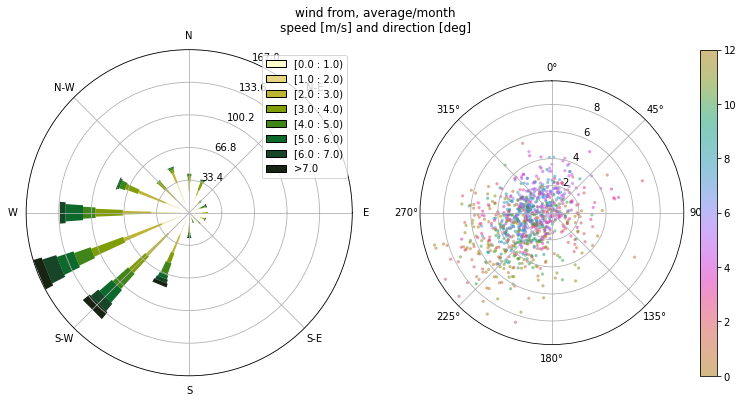

In [10]:
slr.plots.wind_plot(monthly_wind_df)

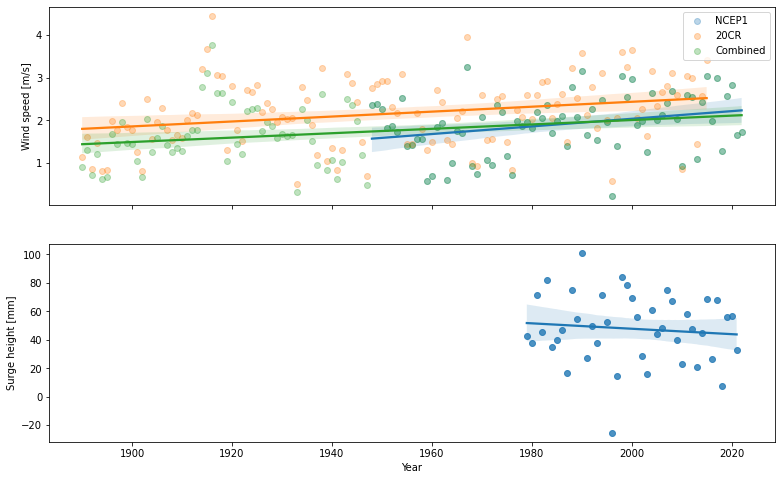

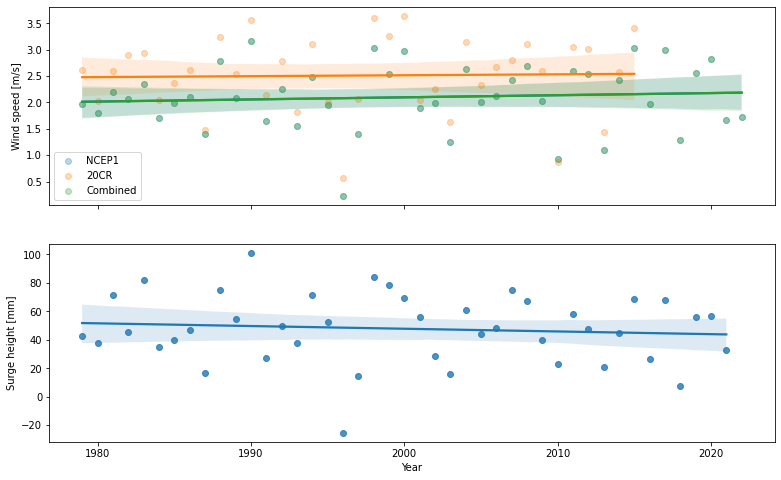

In [11]:
slr.plots.wind_trends(annual_wind_products, annual_gtsm_df, lowess=False, start_year=1890);
slr.plots.wind_trends(annual_wind_products, annual_gtsm_df, lowess=False, start_year=1979);

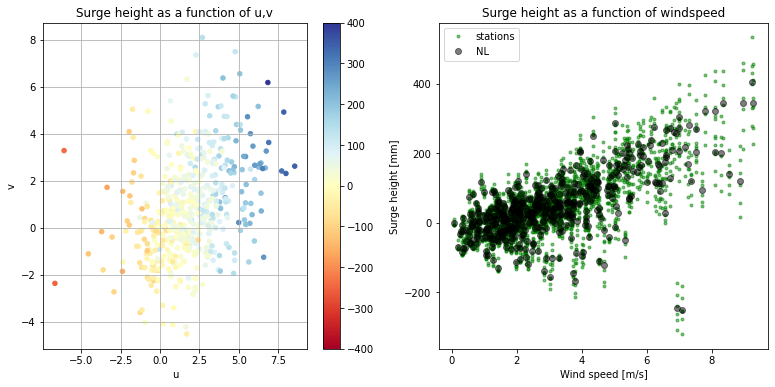

In [12]:
slr.plots.surge_vs_wind(monthly_gtsm_df, monthly_wind_df);

In [13]:
selected_stations = slr.psmsl.add_series_to_stations(selected_stations, wind_product=wind_product)
# each station should now have surge

found point 52.3799 3.75
found point 53.0 3.0


Now that we have all data downloaded. We added wind and the surge to the annual data for each station, we can compute the mean.

In [14]:
# compute the mean, only for annual
selected_stations = slr.psmsl.add_aggregated_stations(selected_stations)


In [15]:
# pick the station
if drop_delfzijl:
    mean_df = selected_stations.loc[10001, "rlr_annual"]
else:
    mean_df = selected_stations.loc[10000, "rlr_annual"]

# Compute surge anomaly corrected waterlevel
# TODO: this should be done in function that reads the data, also compute height - surge anomaly
# mean_df['height-surge'] = mean_df['height'] - (mean_df['surge_mm'] - mean_df['surge_mm'].mean())
# mean_df.plot('year', ['height', 'height-surge'])
mean_df

,t,year,height,u2,v2,surge_mm,station,height - surge,height - surge anomaly
28,1890-01-01,1890.0,-203.4,6.311259,2.364999,45.138458,10001,-248.538458,-203.400000
29,1891-01-01,1891.0,-189.4,6.311259,2.364999,45.138458,10001,-234.538458,-189.400000
30,1892-01-01,1892.0,-174.4,6.311259,2.364999,45.138458,10001,-219.538458,-174.400000
31,1893-01-01,1893.0,-154.0,6.311259,2.364999,45.138458,10001,-199.138458,-154.000000
32,1894-01-01,1894.0,-147.0,6.311259,2.364999,45.138458,10001,-192.138458,-147.000000
...,...,...,...,...,...,...,...,...,...
155,2017-01-01,2017.0,94.2,11.298989,2.050601,64.108285,10001,30.091715,75.230173
156,2018-01-01,2018.0,26.2,4.296787,2.208767,5.465940,10001,20.734060,65.872519
157,2019-01-01,2019.0,92.0,7.962882,4.212188,53.384473,10001,38.615527,83.753986
158,2020-01-01,2020.0,96.6,9.839990,6.934233,53.691681,10001,42.908319,88.046778


In [16]:
mean_df.iloc[-1], mean_df.iloc[0]

(t                         2021-01-01 00:00:00
 year                                   2021.0
 height                                   75.8
 u2                                   4.822271
 v2                                   0.255049
 surge_mm                            30.632732
 station                                 10001
 height - surge                      45.167268
 height - surge anomaly              90.305726
 Name: 159, dtype: object,
 t                         1890-01-01 00:00:00
 year                                   1890.0
 height                                 -203.4
 u2                                   6.311259
 v2                                   2.364999
 surge_mm                            45.138458
 station                                 10001
 height - surge                    -248.538458
 height - surge anomaly                 -203.4
 Name: 28, dtype: object)

In [17]:
bokeh.io.show(
    slr.plots.timeseries_plot(
        selected_stations=selected_stations, 
        mean_df=mean_df, 
        dataset_name=default_dataset_name
    )
)


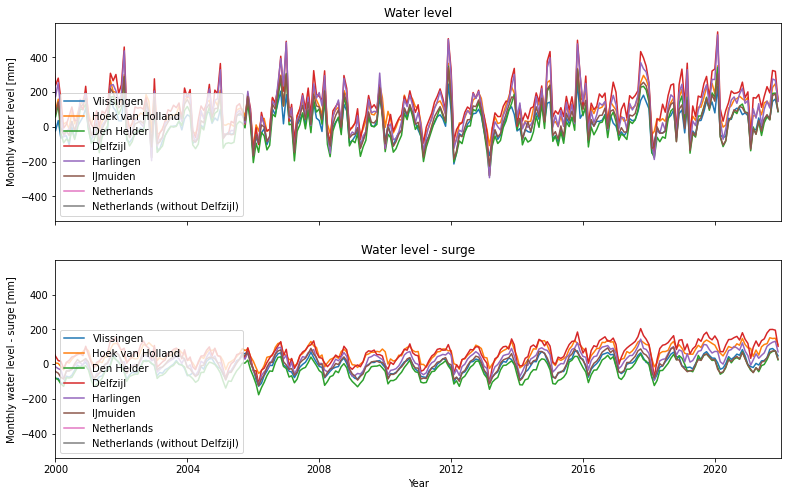

In [18]:
slr.plots.surge_vs_waterlevel(
    selected_stations
)

In [19]:
bokeh.io.show(
    slr.plots.timeseries_plot(
        selected_stations=selected_stations, 
        mean_df=mean_df, 
        dataset_name='rlr_monthly'
    )
)

In [20]:
slr.tables.top_n_tables(selected_stations)

Methods
=====
Now we can define the statistical model. The "current sea-level rise" is defined by the following formula. Please note that t is relative to the epoch of 1970. This model is referred to as `linear_model` in the code. 
$H(t) = a + b_{trend}(t) + b_{u}\cos(2\pi\frac{t}{18.613}) + b_{v}\sin(2\pi\frac{t}{18.613}) + b_{wind_{u^2}}wind_{u^2}(t) + b_{wind_{v^2}}wind_{v^2}(t) + \varepsilon(t-1) + \varepsilon(t)$

The terms are refered to as Constant ($a$), Trend ($b_{trend}$), Nodal U ($b_u$) and Nodal V ($b_v$), Wind ($b_{wind^2}$), the autoregressive term $\varepsilon(t-1)$ and error $\varepsilon$. 


Alternative models are used to detect if sea-level rise is increasing. These models include the broken linear model, defined by a possible change in trend starting at 1993. This timespan is the start of the "satellite era" (start of TOPEX/Poseidon measurements), it is also often referred to as the start of acceleration because the satellite measurements tend to show a higher rate of sea level than the "tide-gauge era" (1900-2000). If this model fits better than the linear model, one could say that there is a "increase in sea-level rise".  This model is refered to as `broken_linear_model`. These models are covered in the section [Sea-level acceleration](#Is-there-a-sea-level-acceleration?).

$H(t) = a + b_{trend}(t) + b_{broken}(t > 1993)*(t-1993) + b_{u}\cos(2\pi\frac{t}{18.613}) + b_{v}\sin(2\pi\frac{t}{18.613}) + b_{wind_{u^2}}wind_{u^2}(t) + b_{wind_{v^2}}wind_{v^2}(t) + \varepsilon(t-1) + \varepsilon(t)$

Another way to look at increased sea-level rise is to look at sea-level acceleration. To detect sea-level acceleration one can use a quadratic model. This model is referred to as `quadratic_model`. 

$H(t) = a + b_{trend}(t) + b_{quadratic}(t*t) + b_{u}\cos(2\pi\frac{t}{18.613}) + b_{v}\sin(2\pi\frac{t}{18.613}) + b_{wind_{u^2}}wind_{u^2}(t) + b_{wind_{v^2}}wind_{v^2}(t) + \varepsilon(t-1) + \varepsilon(t)$



We can compare the model with and without wind. Wind drives the storm surge at the coast. If there is a strong wind blowing it can raise the waterlevel by meters, 2 meter is not uncommon. If the wind keeps blowing for two days this will raise the annual averaged waterlevel by more than a centimeter, even if it occurs during low tide. 
We can verify that wind is an important factor for the average sea level by comparing the model with and without wind. 
Things to check for include: 
- Durbin Watson should be >1 for no worries, >2 for no autocorrelation
- JB should be non-significant for normal residuals
- abs(x2.t) + abs(x3.t) should be > 3, otherwise adding nodal is not useful
- The model with wind should also be significant better, check F value difference with 2 and N-5 degrees of freedom. 

In [21]:
# first the model 
quantity = 'height'
yname = "Sea surface height"
nodal_until = None
if subtract_surge:
    quantity = "height - surge anomaly"
    yname = "Sea surface height - surge anomaly"
    nodal_until = 1979

linear_without_wind_fit, linear_without_wind_names = slr.models.linear_model(
    mean_df, with_wind=False, with_ar=True, quantity=quantity,
    nodal_until=nodal_until
)
table = linear_without_wind_fit.summary(
    yname=yname, 
    xname=linear_without_wind_names, 
    title='Linear model without (1890-current)'
)
IPython.display.display(table)

# and then the model with wind
# explictly use height here, otherwise we might use height - surge
linear_with_wind_fit, linear_with_wind_names = slr.models.linear_model(
    mean_df, 
    with_wind=True, 
    nodal_until=None,
    with_ar=True,
    quantity='height'
)
table = linear_with_wind_fit.summary(
    yname="Sea surface height", 
    xname=linear_with_wind_names,
    title='Linear model with wind (1948-current)'
)
IPython.display.display(table)

# Wikipedia, based on Akaike(1974): Given a set of candidate models 
# for the data, the preferred model is the one with the minimum AIC value. 
# If with_wind is None, pick it based on AIC
if with_wind is None:
    if (linear_without_wind_fit.aic < linear_with_wind_fit.aic):
        print('The linear model without wind is a higher quality model (smaller AIC) than the linear model with wind.')
        with_wind = False
    else:
        print('The linear model with wind is a higher quality model (smaller AIC) than the linear model without wind.')
        with_wind = True

if subtract_surge:
    assert with_wind == False, "If you subtract surge, you should set with_wind to False"
    print("We are not modelling wind because we are already modelling surge. Otherwise we would correct for wind twice over the period where we have surge.")

if with_wind:
    linear_fit = linear_with_wind_fit
    linear_names = linear_with_wind_names
else: 
    linear_fit = linear_without_wind_fit
    linear_names = linear_without_wind_names


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Linear model without (1890-current)                              
==============================================================================================
Dep. Variable:     Sea surface height - surge anomaly   R-squared:                       0.839
Model:                                          GLSAR   Adj. R-squared:                  0.835
Method:                                 Least Squares   F-statistic:                     296.6
Date:                                Tue, 14 Feb 2023   Prob (F-statistic):           3.61e-57
Time:                                        18:02:03   Log-Likelihood:                -599.60
No. Observations:                                 131   AIC:                             1207.
Df Residuals:                                     127   BIC:                             1219.
Df Model:                                           3                                         
Covariance Type:                                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -33.8807      2.681    -12.639      0.000     -39.135     -28.627
Trend          1.9218      0.065     29.692      0.000       1.795       2.049
Nodal U        8.7354      5.387      1.622      0.105      -1.823      19.294
Nodal V      -11.7608      5.414     -2.172      0.030     -22.372      -1.150
==============================================================================
Omnibus:                        3.828   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.147   Jarque-Bera (JB):                3.264
Skew:                          -0.335   Prob(JB):                        0.195
Kurtosis:                       3.386   Cond. No.                         68.9
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Linear model with wind (1948-current)                     
==============================================================================
Dep. Variable:     Sea surface height   R-squared:                       0.874
Model:                          GLSAR   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     247.0
Date:                Tue, 14 Feb 2023   Prob (F-statistic):           5.35e-63
Time:                        18:02:03   Log-Likelihood:                -588.22
No. Observations:                 131   AIC:                             1188.
Df Residuals:                     125   BIC:                             1206.
Df Model:                           5                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -79.5786      5.654    -14.074      0.000     -90.661     -68.496
Trend          1.8628      0.067     27.998      0.000       1.732       1.993
Nodal U        3.5836      3.506      1.022      0.307      -3.287      10.455
Nodal V      -12.6386      3.468     -3.644      0.000     -19.436      -5.841
Wind $u^2$     7.2661      0.680     10.693      0.000       5.934       8.598
Wind $v^2$    -0.4435      1.039     -0.427      0.670      -2.481       1.594
==============================================================================
Omnibus:                        1.057   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.589   Jarque-Bera (JB):                0.630
Skew:                          -0.046   Prob(JB):                        0.730
Kurtosis:                       3.327   Cond. No.                         92.5
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

We are not modelling wind because we are already modelling surge. Otherwise we would correct for wind twice over the period where we have surge.


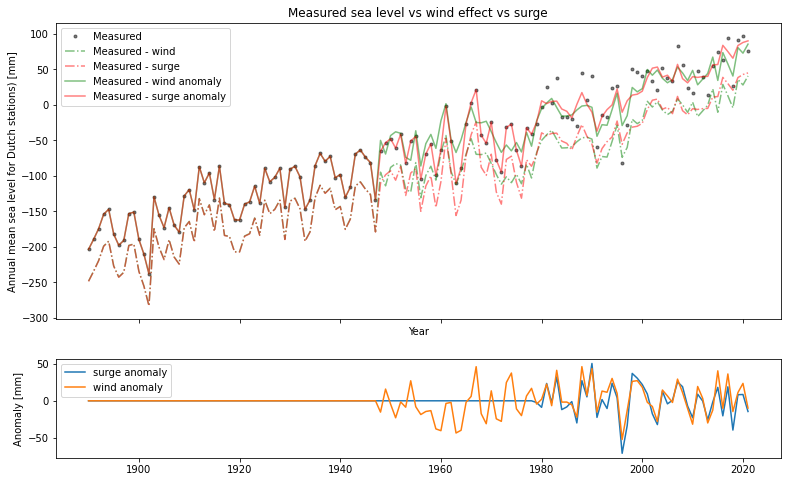

In [22]:
slr.plots.wind_anomaly_vs_surge_anomaly(
    mean_df, 
    fit=linear_with_wind_fit, 
    names=linear_with_wind_names
);


In [23]:
if subtract_surge:
    print("This figure is not used when surge is subtracted.")
fig = slr.plots.wind_vs_no_wind(
    mean_df=mean_df, 
    quantity=quantity, 
    yname=yname,
    linear_with_wind_fit=linear_with_wind_fit, 
    linear_without_wind_fit=linear_without_wind_fit
)
bokeh.io.show(fig)

This figure is not used when surge is subtracted.


In [24]:
linear_fit.summary(xname=linear_names)

<class 'statsmodels.iolib.summary.Summary'>
"""
                             GLSAR Regression Results                             
==================================================================================
Dep. Variable:     height - surge anomaly   R-squared:                       0.839
Model:                              GLSAR   Adj. R-squared:                  0.835
Method:                     Least Squares   F-statistic:                     296.6
Date:                    Tue, 14 Feb 2023   Prob (F-statistic):           3.61e-57
Time:                            18:02:03   Log-Likelihood:                -599.60
No. Observations:                     131   AIC:                             1207.
Df Residuals:                         127   BIC:                             1219.
Df Model:                               3                                         
Covariance Type:                      HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -33.8807      2.681    -12.639      0.000     -39.135     -28.627
Trend          1.9218      0.065     29.692      0.000       1.795       2.049
Nodal U        8.7354      5.387      1.622      0.105      -1.823      19.294
Nodal V      -11.7608      5.414     -2.172      0.030     -22.372      -1.150
==============================================================================
Omnibus:                        3.828   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.147   Jarque-Bera (JB):                3.264
Skew:                          -0.335   Prob(JB):                        0.195
Kurtosis:                       3.386   Cond. No.                         68.9
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

Regional variability
=====================
It is known that the sea-level rise is not constant along the coast. The figures below show that the sea-level is rising faster at some stations. Some of these variations go back to the 1900's. There are several coastal interventions with known effect to the stations. The construction of the [Afsluitdijk](https://en.wikipedia.org/wiki/Afsluitdijk) (1927-1932), the [Oosterscheldekering](https://en.wikipedia.org/wiki/Oosterscheldekering) (1969-1987), the [Maeslantkering](https://en.wikipedia.org/wiki/Maeslantkering) (1991-1997) all have influence on the mean sea level, mainly due to changes in tidal amplitudes. 

Using the mean of the six tidal guages is the current approach. There are alternatives, for example one can use the principal component of the differences (between months/years). It is then assumed that only the common variance shared accross all stations is representative of the shared sea level. Most of the variance is shared between all stations and this results in a similar trend as using the mean. This method is referred to as EOF, PCA or SSA. See the analysis folder for an example.

In [25]:
station_fits = {}
for name, station in selected_stations.iterrows():
    df = station[default_dataset_name]
    df = df[df.year >= 1890]
    fit, names = slr.models.linear_model(df, with_wind=with_wind, nodal_until=nodal_until, quantity=quantity)
    smry = fit.summary(xname=names, title=station['name'])
    # somehow a formatted name is not showing up
    print(station['name'], quantity)
    station_fits[name] = fit

    IPython.display.display(smry.tables[1])

Vlissingen height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-76.3776,3.129,-24.407,0.000,-82.511,-70.244
Trend,2.1831,0.097,22.474,0.000,1.993,2.373
Nodal U,7.4974,6.560,1.143,0.253,-5.361,20.355
Nodal V,-13.9467,6.720,-2.075,0.038,-27.118,-0.776


Hoek van Holland height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-6.9385,3.428,-2.024,0.043,-13.657,-0.220
Trend,2.3841,0.077,31.150,0.000,2.234,2.534
Nodal U,3.0795,7.120,0.433,0.665,-10.875,17.035
Nodal V,-8.0044,6.820,-1.174,0.241,-21.371,5.362


Den Helder height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-57.5811,3.332,-17.279,0.000,-64.112,-51.050
Trend,1.5495,0.079,19.614,0.000,1.395,1.704
Nodal U,8.4841,6.362,1.334,0.182,-3.985,20.953
Nodal V,-14.0834,7.299,-1.929,0.054,-28.390,0.223


Delfzijl height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,31.2037,3.788,8.238,0.000,23.780,38.628
Trend,2.0487,0.099,20.662,0.000,1.854,2.243
Nodal U,12.1486,7.868,1.544,0.123,-3.273,27.570
Nodal V,-12.6981,6.615,-1.920,0.055,-25.664,0.267


Harlingen height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,16.1624,3.745,4.315,0.000,8.822,23.503
Trend,1.3907,0.089,15.671,0.000,1.217,1.565
Nodal U,7.9024,7.187,1.100,0.272,-6.183,21.988
Nodal V,-9.0248,6.809,-1.325,0.185,-22.370,4.320


IJmuiden height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-44.3547,3.672,-12.081,0.000,-51.551,-37.159
Trend,2.1001,0.104,20.248,0.000,1.897,2.303
Nodal U,16.7042,7.808,2.139,0.032,1.401,32.007
Nodal V,-14.0882,7.636,-1.845,0.065,-29.054,0.878


Netherlands height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-23.0465,2.730,-8.442,0.000,-28.397,-17.696
Trend,1.9429,0.066,29.219,0.000,1.813,2.073
Nodal U,9.3018,5.495,1.693,0.090,-1.468,20.071
Nodal V,-11.9064,5.338,-2.230,0.026,-22.369,-1.444


Netherlands (without Delfzijl) height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-33.8807,2.681,-12.639,0.000,-39.135,-28.627
Trend,1.9218,0.065,29.692,0.000,1.795,2.049
Nodal U,8.7354,5.387,1.622,0.105,-1.823,19.294
Nodal V,-11.7608,5.414,-2.172,0.030,-22.372,-1.150


In [26]:
station_fits = {}
for name, station in selected_stations.iterrows():
    df = station[default_dataset_name]
    df = df[df.year >= 1890]
    fit, names = slr.models.broken_linear_model(df, with_wind=with_wind, nodal_until=nodal_until, quantity=quantity)
    smry = fit.summary(xname=names, title=station['name'])
    # somehow a formatted name is not showing up
    print(station['name'], quantity)
    station_fits[name] = fit

    IPython.display.display(smry.tables[1])

Vlissingen height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-79.8201,4.231,-18.865,0.000,-88.113,-71.527
Trend,2.0946,0.139,15.100,0.000,1.823,2.367
+trend (1993),0.6959,0.477,1.460,0.144,-0.238,1.630
Nodal U,7.3235,6.498,1.127,0.260,-5.413,20.060
Nodal V,-13.7079,6.731,-2.037,0.042,-26.900,-0.516


Hoek van Holland height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-11.3282,4.872,-2.325,0.020,-20.877,-1.780
Trend,2.2720,0.113,20.173,0.000,2.051,2.493
+trend (1993),0.8933,0.464,1.924,0.054,-0.017,1.803
Nodal U,2.8440,6.901,0.412,0.680,-10.682,16.370
Nodal V,-7.6539,6.693,-1.144,0.253,-20.771,5.464


Den Helder height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-64.0981,4.469,-14.344,0.000,-72.856,-55.340
Trend,1.3834,0.107,12.954,0.000,1.174,1.593
+trend (1993),1.3272,0.450,2.950,0.003,0.446,2.209
Nodal U,8.1781,5.958,1.373,0.170,-3.499,19.855
Nodal V,-13.5499,6.982,-1.941,0.052,-27.235,0.135


Delfzijl height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,20.8558,4.371,4.771,0.000,12.288,29.423
Trend,1.7863,0.117,15.210,0.000,1.556,2.016
+trend (1993),2.1099,0.501,4.215,0.000,1.129,3.091
Nodal U,11.6830,7.152,1.634,0.102,-2.335,25.701
Nodal V,-11.7988,5.914,-1.995,0.046,-23.389,-0.208


Harlingen height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,5.3645,4.462,1.202,0.229,-3.380,14.109
Trend,1.1173,0.108,10.386,0.000,0.906,1.328
+trend (1993),2.1984,0.451,4.871,0.000,1.314,3.083
Nodal U,7.2466,6.234,1.162,0.245,-4.972,19.465
Nodal V,-8.0091,6.053,-1.323,0.186,-19.874,3.855


IJmuiden height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-45.2061,5.177,-8.732,0.000,-55.353,-35.059
Trend,2.0782,0.151,13.729,0.000,1.782,2.375
+trend (1993),0.1723,0.539,0.320,0.749,-0.884,1.229
Nodal U,16.6654,7.811,2.134,0.033,1.356,31.975
Nodal V,-14.0294,7.629,-1.839,0.066,-28.982,0.924


Netherlands height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-29.0083,3.566,-8.135,0.000,-35.997,-22.020
Trend,1.7916,0.089,20.162,0.000,1.617,1.966
+trend (1993),1.2202,0.367,3.323,0.001,0.500,1.940
Nodal U,9.0088,5.146,1.751,0.080,-1.077,19.095
Nodal V,-11.3781,5.054,-2.251,0.024,-21.285,-1.472


Netherlands (without Delfzijl) height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-38.9872,3.625,-10.755,0.000,-46.092,-31.882
Trend,1.7921,0.090,19.936,0.000,1.616,1.968
+trend (1993),1.0449,0.364,2.867,0.004,0.331,1.759
Nodal U,8.4802,5.120,1.656,0.098,-1.554,18.515
Nodal V,-11.3159,5.212,-2.171,0.030,-21.532,-1.100


In [27]:
station_fits[24].model.endog

array([-1.51000000e+02, -1.27000000e+02, -1.27000000e+02, -8.30000000e+01,
       -1.16000000e+02, -1.28000000e+02, -1.22000000e+02, -1.22000000e+02,
       -6.50000000e+01, -9.10000000e+01, -1.12000000e+02, -1.30000000e+02,
       -1.61000000e+02, -3.60000000e+01, -1.34000000e+02, -1.96000000e+02,
       -1.15000000e+02, -1.30000000e+02, -1.23000000e+02, -7.60000000e+01,
       -6.60000000e+01, -5.40000000e+01,  1.40000000e+01, -4.50000000e+01,
       -4.00000000e+01, -8.00000000e+01, -9.00000000e+00, -7.30000000e+01,
       -8.70000000e+01, -1.12000000e+02, -8.50000000e+01, -1.70000000e+01,
       -7.60000000e+01, -5.20000000e+01, -8.70000000e+01, -5.00000000e+00,
       -1.70000000e+01, -4.30000000e+01, -3.00000000e+01, -6.90000000e+01,
       -4.70000000e+01, -1.70000000e+01, -3.40000000e+01, -7.90000000e+01,
       -5.70000000e+01, -1.40000000e+01, -1.50000000e+01, -5.20000000e+01,
       -5.00000000e+00, -6.80000000e+01, -4.70000000e+01, -9.90000000e+01,
       -7.80000000e+01, -

In [28]:
p = slr.plots.station_comparison_linear_vs_broken_linear(
    selected_stations=selected_stations, 
    quantity=quantity, 
    yname=yname, 
    with_wind=with_wind,
    dataset_name=default_dataset_name
)
p.plot_height = 800
p.legend.location = "top_left"
bokeh.io.show(p)


Another thing we can look at is the regional variability of unexplained variance. The largest peaks are found in Delfzijl at the start of the measurements. The measured waterlevel was lower in that year. Delfzijl is more affected by storm surges than most other stations due to it's position in the Eems. Another outlier is the measurement in the 30's in Den Helder, this is likely due to the construction of the Afsluitdijk. The other residuals mostly occur on all stations at the same time. This indicates that it is more likely that our estimate of the wind is not optimal yet. We do see a periodicity in the residuals of about 6 years. This does not match with any of the known climate indices. 
Variance descreasess after 1948 because the reanalysis of wind is included after that. 

Is there a sea-level acceleration?
==================

The following section computes two common models to detect sea-level acceleration.  The broken linear model expects that sea level has been rising faster since 1990. The quadratic model assumes that the sea-level is accelerating continuously. Both models are compared to the linear model. The extra terms are tested for significance and the AIC is computed to see which model is "better". 

In [29]:
# use wind if it was a better model
broken_linear_fit, broken_linear_names = slr.models.broken_linear_model(
    mean_df, 
    with_wind=with_wind, 
    nodal_until=nodal_until,
    quantity=quantity
)

In [30]:
quadratic_fit, quadratic_names = slr.models.quadratic_model(mean_df, with_wind=with_wind, quantity=quantity)
broken_quadratic_fit, broken_quadratic_names = slr.models.broken_quadratic_model(
    mean_df, 
    with_wind=with_wind,
    nodal_until=nodal_until,
    quantity=quantity,
    start_acceleration=1960
    
)

In [31]:
# summary of the broken linear model
print('autoregressive parameter rho = %s' % broken_linear_fit.history['rho'][-1])
IPython.display.display(broken_linear_fit.summary(yname=yname, xname=broken_linear_names))


autoregressive parameter rho = [0.22918722]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   GLSAR Regression Results                                   
==============================================================================================
Dep. Variable:     Sea surface height - surge anomaly   R-squared:                       0.855
Model:                                          GLSAR   Adj. R-squared:                  0.850
Method:                                 Least Squares   F-statistic:                     351.7
Date:                                Tue, 14 Feb 2023   Prob (F-statistic):           2.57e-67
Time:                                        18:02:03   Log-Likelihood:                -597.43
No. Observations:                                 131   AIC:                             1205.
Df Residuals:                                     126   BIC:                             1219.
Df Model:                                           4                                         
Covariance Type:                                  HC0                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant        -38.9872      3.625    -10.755      0.000     -46.092     -31.882
Trend             1.7921      0.090     19.936      0.000       1.616       1.968
+trend (1993)     1.0449      0.364      2.867      0.004       0.331       1.759
Nodal U           8.4802      5.120      1.656      0.098      -1.554      18.515
Nodal V         -11.3159      5.212     -2.171      0.030     -21.532      -1.100
==============================================================================
Omnibus:                        2.640   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.267   Jarque-Bera (JB):                2.112
Skew:                          -0.272   Prob(JB):                        0.348
Kurtosis:                       3.301   Cond. No.                         69.6
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [32]:
# summary of the quadratic model
print('autoregressive parameter rho = %s' % quadratic_fit.history['rho'][-1])

quadratic_fit.summary(yname=yname, xname=quadratic_names)

autoregressive parameter rho = [0.23575845]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   GLSAR Regression Results                                   
==============================================================================================
Dep. Variable:     Sea surface height - surge anomaly   R-squared:                       0.852
Model:                                          GLSAR   Adj. R-squared:                  0.848
Method:                                 Least Squares   F-statistic:                     307.1
Date:                                Tue, 14 Feb 2023   Prob (F-statistic):           6.13e-64
Time:                                        18:02:03   Log-Likelihood:                -597.63
No. Observations:                                 131   AIC:                             1205.
Df Residuals:                                     126   BIC:                             1220.
Df Model:                                           4                                         
Covariance Type:                                  HC0                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Constant (in year 1970)   -37.6653      4.233     -8.897      0.000     -45.963     -29.368
Trend                       1.9936      0.065     30.704      0.000       1.866       2.121
Acceleration                0.0029      0.002      1.441      0.150      -0.001       0.007
Nodal U                     4.1526      3.677      1.129      0.259      -3.055      11.360
Nodal V                   -12.4349      3.722     -3.341      0.001     -19.730      -5.140
==============================================================================
Omnibus:                        2.392   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.302   Jarque-Bera (JB):                1.872
Skew:                          -0.247   Prob(JB):                        0.392
Kurtosis:                       3.314   Cond. No.                     3.35e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 3.35e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
# summary of the broken quadratic model
print('autoregressive parameter rho = %s' % broken_quadratic_fit.history['rho'][-1])
IPython.display.display(broken_quadratic_fit.summary(yname=yname, xname=broken_quadratic_names))


autoregressive parameter rho = [0.23620974]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   GLSAR Regression Results                                   
==============================================================================================
Dep. Variable:     Sea surface height - surge anomaly   R-squared:                       0.852
Model:                                          GLSAR   Adj. R-squared:                  0.847
Method:                                 Least Squares   F-statistic:                     321.7
Date:                                Tue, 14 Feb 2023   Prob (F-statistic):           4.30e-65
Time:                                        18:02:03   Log-Likelihood:                -597.83
No. Observations:                                 131   AIC:                             1206.
Df Residuals:                                     126   BIC:                             1220.
Df Model:                                           4                                         
Covariance Type:                                  HC0                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Constant (in year 1960)   -58.7132      4.393    -13.366      0.000     -67.323     -50.104
Trend                       1.7479      0.123     14.235      0.000       1.507       1.989
Acceleration from 1960      0.0082      0.004      2.070      0.038       0.000       0.016
Nodal U                     8.4440      5.166      1.634      0.102      -1.682      18.570
Nodal V                   -11.3388      5.279     -2.148      0.032     -21.686      -0.991
==============================================================================
Omnibus:                        1.867   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.393   Jarque-Bera (JB):                1.407
Skew:                          -0.225   Prob(JB):                        0.495
Kurtosis:                       3.236   Cond. No.                     2.02e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 2.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
fits = [
    {
        "name": "linear",
        "fit": linear_fit,
        "names": linear_names
    },
    {
        "name": "linear_with_wind",
        "fit": linear_with_wind_fit,
        "names": linear_with_wind_names
    },
    {
        "name": "linear_without_wind",
        "fit": linear_without_wind_fit,
        "names": linear_without_wind_names
    },
    {
        "name": "broken_linear", 
        "fit": broken_linear_fit,
        "names": broken_linear_names
    },
    {
        "name": "quadratic",
        "fit": quadratic_fit,
        "names": quadratic_names
    },
    {
        "name": "broken_quadratic",
        "fit": broken_quadratic_fit,
        "names": broken_quadratic_names
    }
]

# convert and add information
fits_df = slr.tables.fits_to_fits_df(fits)


# Best acceleration model on top
fits_df = fits_df.sort_values('aic')
# Manual select best model
selected_fit = fits_df.query('name =="broken_linear"').iloc[0]
# export without fit, as that does not fit in csv files
drop_columns = ['fit', 'exog', 'prediction', 'prediction_mean_tide', 'prediction_mean_wind', 'prediction_mean_tide_mean_wind']
export_fits_df = fits_df.drop(columns=drop_columns)
export_fits_df.to_csv('../data/deltares/results/fits.csv')

In [35]:
fits_df

,name,fit,names,aic,F,df_model,prediction,has_tide,has_wind,prediction_mean_tide,prediction_mean_wind,prediction_mean_tide_mean_wind,exog
1,linear_with_wind,<statsmodels.regression.linear_model.Regressio...,"[Constant, Trend, Nodal U, Nodal V, Wind $u^2$...",1188.440027,247.038518,5.0,<statsmodels.regression._prediction.Prediction...,True,True,<statsmodels.regression._prediction.Prediction...,<statsmodels.regression._prediction.Prediction...,<statsmodels.regression._prediction.Prediction...,Constant Trend Nodal U Nodal V Wind...
3,broken_linear,<statsmodels.regression.linear_model.Regressio...,"[Constant, Trend, +trend (1993), Nodal U, Noda...",1204.868337,351.667585,4.0,<statsmodels.regression._prediction.Prediction...,True,False,<statsmodels.regression._prediction.Prediction...,NaN,NaN,Constant Trend +trend (1993) Nodal U ...
4,quadratic,<statsmodels.regression.linear_model.Regressio...,"[Constant (in year 1970), Trend, Acceleration,...",1205.251503,307.105718,4.0,<statsmodels.regression._prediction.Prediction...,True,False,<statsmodels.regression._prediction.Prediction...,NaN,NaN,Constant (in year 1970) Trend Accelerat...
5,broken_quadratic,<statsmodels.regression.linear_model.Regressio...,"[Constant (in year 1960), Trend, Acceleration ...",1205.660696,321.710777,4.0,<statsmodels.regression._prediction.Prediction...,True,False,<statsmodels.regression._prediction.Prediction...,NaN,NaN,Constant (in year 1960) Trend Accelerat...
0,linear,<statsmodels.regression.linear_model.Regressio...,"[Constant, Trend, Nodal U, Nodal V]",1207.205040,296.629671,3.0,<statsmodels.regression._prediction.Prediction...,True,False,<statsmodels.regression._prediction.Prediction...,NaN,NaN,Constant Trend Nodal U Nodal V 0 ...
2,linear_without_wind,<statsmodels.regression.linear_model.Regressio...,"[Constant, Trend, Nodal U, Nodal V]",1207.205040,296.629671,3.0,<statsmodels.regression._prediction.Prediction...,True,False,<statsmodels.regression._prediction.Prediction...,NaN,NaN,Constant Trend Nodal U Nodal V 0 ...


# Constant wind trend
Here we compute the linear model with constant wind and tide

In [36]:
mean_df

,t,year,height,u2,v2,surge_mm,station,height - surge,height - surge anomaly
28,1890-01-01,1890.0,-203.4,6.311259,2.364999,45.138458,10001,-248.538458,-203.400000
29,1891-01-01,1891.0,-189.4,6.311259,2.364999,45.138458,10001,-234.538458,-189.400000
30,1892-01-01,1892.0,-174.4,6.311259,2.364999,45.138458,10001,-219.538458,-174.400000
31,1893-01-01,1893.0,-154.0,6.311259,2.364999,45.138458,10001,-199.138458,-154.000000
32,1894-01-01,1894.0,-147.0,6.311259,2.364999,45.138458,10001,-192.138458,-147.000000
...,...,...,...,...,...,...,...,...,...
155,2017-01-01,2017.0,94.2,11.298989,2.050601,64.108285,10001,30.091715,75.230173
156,2018-01-01,2018.0,26.2,4.296787,2.208767,5.465940,10001,20.734060,65.872519
157,2019-01-01,2019.0,92.0,7.962882,4.212188,53.384473,10001,38.615527,83.753986
158,2020-01-01,2020.0,96.6,9.839990,6.934233,53.691681,10001,42.908319,88.046778


In [37]:
# before reanalysis started wind  is filled  in with mean,  let's use it from there
mean_wind = mean_df.set_index('year').loc[1890][['u2', 'v2']]
const = linear_with_wind_fit.params['const'] 
trend = linear_with_wind_fit.params['x1'] 
u2 = linear_with_wind_fit.params['x4'] 
v2 = linear_with_wind_fit.params['x5'] 

# linear_with_wind_fit.predict(mean_df)
linear_with_wind_fit.model.exog.shape, linear_with_wind_fit.model.exog_names
exog_df = pd.DataFrame(
    linear_with_wind_fit.model.exog, 
    columns=linear_with_wind_fit.model.exog_names
).copy()
msg = 'Check variable numbers in code below, they changed'
assert linear_with_wind_names == ['Constant', 'Trend', 'Nodal U', 'Nodal V', 'Wind $u^2$', 'Wind $v^2$'], msg
# take 0 nodal tide
exog_df['x2'] = 0 # 
exog_df['x3'] = 0 # 
# take the average wind
exog_df['x4'] = mean_wind['u2']
exog_df['x5'] = mean_wind['v2']
linear_with_mean_wind = linear_with_wind_fit.predict(exog_df)
linear_with_mean_wind_prediction = linear_with_wind_fit.get_prediction(exog=exog_df)
linear_with_mean_wind_confidence_interval = linear_with_mean_wind_prediction.conf_int(obs=False)
linear_with_mean_wind_prediction_interval = linear_with_mean_wind_prediction.conf_int(obs=True)
linear_with_wind_confidence_interval = linear_with_wind_fit.get_prediction().conf_int(obs=False)
linear_with_wind_prediction_interval = linear_with_wind_fit.get_prediction().conf_int(obs=True)



# Sea level due to tide
The sea level is also varying due to the nodal tide (18.613 year period). Because the nodal tide does not only influence the mean sea level but also the tidal amplitude, the measured amplitude can be different from the theoretical value. In order to get an estimate of the measured nodal tide, for long running tide gauges, you can estimate it using two parameters, the nodal u, v. These u and v are just sin and cosin with a period of 18.613 year and amplitude of 1. If you fit a linear model with these included the fit can determine an optimal amplitude and phase for the nodal tide fit for that station. 

The figure below shows the input nodal u,v and the fitted cycle based on the linear fit with wind. 

t                         2021-01-01 00:00:00
year                                   2021.0
height                                   75.8
u2                                   4.822271
v2                                   0.255049
surge_mm                            30.632732
station                                 10001
height - surge                      45.167268
height - surge anomaly              90.305726
Name: 159, dtype: object

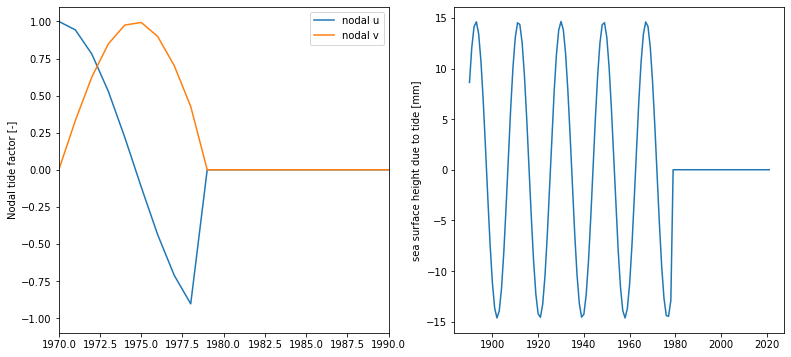

In [38]:
slr.plots.sea_level_due_to_tide(
    mean_df, 
    fit=linear_fit, 
    names=linear_names
);

mean_df.iloc[-1]

# All models combined
The figure below shows an overview of all the calculated variables and models.

In [39]:
bokeh.io.show(slr.plots.model_compare_plot(mean_df, fits_df, quantity=quantity))

# Subtract figure

In [40]:
def subtract_figure(mean_df, linear_with_wind_fit, linear_with_wind_names):
    """
    Show an interactive figure where you can subtract the different components. 
    Tide and wind anomalies are based on the linear model with wind. 
    """
    # linear model
    sea_surface_height_due_to_tide_linear = slr.models.tide_effect(linear_with_wind_fit, linear_with_wind_names)
    wind_effect, wind_anomaly = slr.wind.compute_wind_effect_and_anomaly(linear_with_wind_fit, linear_with_wind_names)
    wind_anomaly[mean_df['year'] < 1979]

    surge_anomaly = mean_df['surge_mm'] - mean_df['surge_mm'].mean()
    surge_or_wind = np.where(mean_df['year'] < 1979, wind_anomaly, surge_anomaly)

    fig = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)

    fig.circle(mean_df['year'], mean_df['height'], legend_label='sea surface height', color='black')
    fig.line(mean_df['year'], mean_df['height'] - sea_surface_height_due_to_tide_linear, legend_label='sea surface height - tide', color='purple')
    fig.line(mean_df['year'], mean_df['height - surge anomaly'], legend_label='sea surface height - surge anomaly', color='blue')
    fig.line(mean_df['year'], mean_df['height'] - wind_anomaly , legend_label='sea surface height - wind anomaly', color='orange')
    fig.line(mean_df['year'], mean_df['height - surge anomaly'] - sea_surface_height_due_to_tide_linear, legend_label='sea surface height - surge anomaly - tide', color='red')
    fig.line(mean_df['year'], mean_df['height'] - wind_anomaly - sea_surface_height_due_to_tide_linear, legend_label='sea surface height - wind anomaly - tide', color='green')

    fig.yaxis.axis_label = 'waterlevel [mm] above N.A.P.'
    fig.xaxis.axis_label = 'year'

    fig.legend.click_policy = "hide"
    fig.legend.location = "top_left"
    return fig

bokeh.io.show(subtract_figure(mean_df, linear_with_wind_fit, linear_with_wind_names))



# Export
Here we export the data in csv format. This information is often requested by others.


In [41]:
sea_surface_height_due_to_tide_linear = slr.models.tide_effect(linear_fit, linear_names)
sea_surface_height_due_to_tide_broken_linear = slr.models.tide_effect(broken_linear_fit, broken_linear_names)

export_df = mean_df.copy().reset_index()
export_df['predicted_linear_with_wind'] = linear_with_wind_fit.predict()
export_df['predicted_linear_without_wind'] = linear_without_wind_fit.predict()
export_df['predicted_linear_mean_wind'] = linear_with_mean_wind
export_df['predicted_linear_mean_wind_ci_025'] = linear_with_mean_wind_confidence_interval[:, 0]
export_df['predicted_linear_mean_wind_ci_975'] = linear_with_mean_wind_confidence_interval[:, 1]
export_df['predicted_linear_mean_wind_pi_025'] = linear_with_mean_wind_prediction_interval[:, 0]
export_df['predicted_linear_mean_wind_pi_975'] = linear_with_mean_wind_prediction_interval[:, 1]
export_df['sea_surface_height_due_to_tide_linear']  = sea_surface_height_due_to_tide_linear
export_df['sea_surface_height_due_to_tide_broken_linear']  = sea_surface_height_due_to_tide_broken_linear
export_df['date'] = export_df['year'].apply(lambda year: datetime.date(year=int(year), month=1, day=1))
header = """\
# Sea surface height for the Netherlands based on the 6 main tide gauges. 
# Cite https://doi.org/10.2112/JCOASTRES-D-11-00169.1 (method) https://doi.org/10.5281/zenodo.1065964 (data)
# Lineage: https://doi.org/10.5281/zenodo.1065964 (notebooks/dutch-sea-level-monitor.ipynb)
# year -> year over which sea-level is averaged
# date -> first day of the year over which the sea level is averaged
# height -> mean sea surface height over main tide gauges, based on PSMSL RLR [mm relative to NAP(2005)]
# u2/v2 -> signed squared mean wind velocity offshore [m2/s2]
# surge -> sea surface height correction due to air pressure and wind [m]
# predicted_linear_with_wind -> fitted sea surface height based on linear model with wind and 0 tide [mm relative to NAP(2005)]
# predicted_linear_without_wind -> fitted sea surface height based on linear model with tide [mm relative to NAP(2005)]
# predicted_linear_mean_wind  -> fitted sea surface height based on linear model with wind and mean nodal tide   [mm relative to NAP(2005)]
# predicted_linear_mean_wind_ci_025  -> fitted sea surface height based on linear model with wind and 0 nodal tide, 2.5% confidence interval [mm relative to NAP(2005)]
# predicted_linear_mean_wind_ci_975  -> fitted sea surface height based on linear model with wind and 0 nodal tide, 97.5% confidence interval [mm relative to NAP(2005)]
# predicted_linear_mean_wind_pi_025  -> fitted sea surface height based on linear model with wind and 0 nodal tide, 2.5% prediction interval [mm relative to NAP(2005)]
# predicted_linear_mean_wind_pi_975  -> fitted sea surface height based on linear model with wind and 0 nodal tide, 97.5% prediction interval [mm relative to NAP(2005)]
# sea_surface_height_due_to_tide_linear  -> fitted nodal tide based on linear model  [mm relative to NAP(2005)]
# sea_surface_height_due_to_tide_broken_linear  -> fitted nodal tide based on broken linear model with wind [mm relative to NAP(2005)]
"""

stream = io.StringIO()
stream.write(header)
export_df.to_csv(stream, escapechar='#', index=False)
date = datetime.datetime.now().date()
path = pathlib.Path('../data/deltares/results/dutch-sea-level-monitor-export-{}.csv'.format(date.isoformat()))
path.write_text(stream.getvalue())

38647

In [42]:
header = """\
# Sea surface height for the Netherlands  for the 6 main tide gauges. 
# Cite https://doi.org/10.2112/JCOASTRES-D-11-00169.1 (method) https://doi.org/10.5281/zenodo.1065964 (data)
# Lineage: https://doi.org/10.5281/zenodo.1065964 (notebooks/dutch-sea-level-monitor.ipynb)
# year -> year over which sea-level is averaged
# date -> first day of the year over which the sea level is averaged
# height -> mean sea surface height over main tide gauges, based on PSMSL RLR [mm relative to NAP(2005)]
# u2/v2 -> signed squared mean wind velocity offshore [m2/s2]
# predicted_linear_with_wind -> fitted sea surface height based on linear model with wind and 0 tide [mm relative to NAP(2005)]
"""
dfs = []
for name, station in selected_stations.iterrows():
    df = station[default_dataset_name]
    df = df[df.year >= 1890].copy()
    fit = station_fits[name]
    predicted_linear_with_wind = fit.predict()   
    df['predicted_linear_with_wind'] = predicted_linear_with_wind
    dfs.append(df.reset_index())
export_stations_df = pd.concat(dfs)
stream = io.StringIO()
stream.write(header)
export_stations_df.to_csv(stream, escapechar='#', index=False)
date = datetime.datetime.now().date()
path = pathlib.Path('../data/deltares/results/dutch-sea-level-monitor-export-stations-{}.csv'.format(date.isoformat()))
path.write_text(stream.getvalue())

170869

Conclusions
======
Below are some statements that depend on the output calculated above. 

In [43]:
# this section asserts that we have wind selected (because we use the with_mean_wind fit, which is only available if there is wind)
selected_model = selected_fit['fit']

n_stations = 6
if drop_delfzijl:
    n_stations = 5
if with_wind:
    observed = mean_df.height.iloc[-1] / 10.0 # mm to cm
    height_corrected_cm = linear_with_mean_wind.iloc[-1] / 10 # mm to cm
    height_predicted_cm = linear_with_wind_fit.predict()[-1]/10.0 #mm to cm
    current_year = int(mean_df['year'].iloc[-1])
    rate = linear_fit.params.x1*100.0/10 # mm/yr to cm/century
    t_start = mean_df.year.iloc[0]
    t_end = mean_df.year.iloc[-1]

else:
    observed = mean_df.height.iloc[-1] / 10.0 # mm to cm
    surge_cm = mean_df['surge_mm'].iloc[-1] / 10 # mm to cm
    surge_anomaly_cm = (mean_df['surge_mm'].iloc[-1] - mean_df['surge_mm'].mean()) / 10 # mm to cm
    last_tide_broken_linear_cm = sea_surface_height_due_to_tide_broken_linear[-1] / 10 # mm to cm

    height_corrected_cm = mean_df['height - surge anomaly'].iloc[-1] / 10 # mm to cm
    height_predicted_cm = selected_model.predict()[-1] / 10.0 #mm to cm
    current_year = int(mean_df['year'].iloc[-1])
    
    if selected_fit['name'] == 'broken_linear':
        rate = (selected_model.params['x1'] + selected_model.params['x2'] ) *100.0/10 # mm/yr to cm/century
    else:
        raise ValueError("rate not defined yet for {selected_fit['name']}")
    t_start = mean_df.year.iloc[0]
    t_end = mean_df.year.iloc[-1]

msg = f'''
- The observed water level, based on the {n_stations} main tide gauges, in {current_year} was {observed:.1f} cm above NAP. 
- The 'current average waterlevel', as defined in the sea level monitor, for the year {current_year} is {height_predicted_cm:.1f} cm above NAP. This is the  sea surface height that we would expect.
- The estimated surge height in year {current_year} was {surge_cm:.1f}cm. The surge anomaly was {surge_anomaly_cm:.1f} cm
- The estimated tidal height (fitted with the broken linear model) was {last_tide_broken_linear_cm:.1f} cm

- In a year with the estimated surge we would have expected a sea level of {height_corrected_cm:.1f} cm. 
- The current sea-level rise is {rate:.1f} cm/century based on the {selected_fit["name"]} model {"with" if with_wind else "without"} wind. 
'''

IPython.display.display_markdown(msg, raw=True)




- The observed water level, based on the 5 main tide gauges, in 2021 was 7.6 cm above NAP. 
- The 'current average waterlevel', as defined in the sea level monitor, for the year 2021 is 8.2 cm above NAP. This is the  sea surface height that we would expect.
- The estimated surge height in year 2021 was 3.1cm. The surge anomaly was -1.5 cm
- The estimated tidal height (fitted with the broken linear model) was 0.0 cm

- In a year with the estimated surge we would have expected a sea level of 9.0 cm. 
- The current sea-level rise is 28.4 cm/century based on the broken_linear model without wind. 


In [44]:
if (linear_fit.aic < quadratic_fit.aic):
    print('The linear model is a higher quality model (smaller AIC) than the quadratic model.')
else:
    print('The quadratic model is a higher quality model (smaller AIC) than the linear model.')
if (quadratic_fit.pvalues['x2'] < 0.05):
    print('The quadratic term is bigger than we would have expected under the assumption that there was no quadraticness.')
else:
    print('Under the assumption that there is no quadraticness, we would have expected a quadratic term as big as we have seen.')

The quadratic model is a higher quality model (smaller AIC) than the linear model.
Under the assumption that there is no quadraticness, we would have expected a quadratic term as big as we have seen.


In [45]:
if (linear_fit.aic < broken_linear_fit.aic):
    print('The linear model is a higher quality model (smaller AIC) than the broken linear model.')
else:
    print('The broken linear model is a higher quality model (smaller AIC) than the linear model.')
if (broken_linear_fit.pvalues['x2'] < 0.05):
    print('The trend break is bigger than we would have expected under the assumption that there was no trend break.')
else:
    print('Under the assumption that there is no trend break, we would have expected a trend break as big as we have seen.')
    
    

The broken linear model is a higher quality model (smaller AIC) than the linear model.
The trend break is bigger than we would have expected under the assumption that there was no trend break.


In [46]:
# Show trends before and after 1993 for comparison with altimetry
broken_params = dict(zip(broken_linear_names, broken_linear_fit.params.values))
trend_since_1993 = broken_params['Trend'] + broken_params['+trend (1993)']
print('The trend since 1993 is {:.2f} mm/year. This period can be used to compare with satellite altimetry.'.format(trend_since_1993))
print('The trend before 1993 was {:.2f} mm/year'.format(broken_params['Trend']))


The trend since 1993 is 2.84 mm/year. This period can be used to compare with satellite altimetry.
The trend before 1993 was 1.79 mm/year
